In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

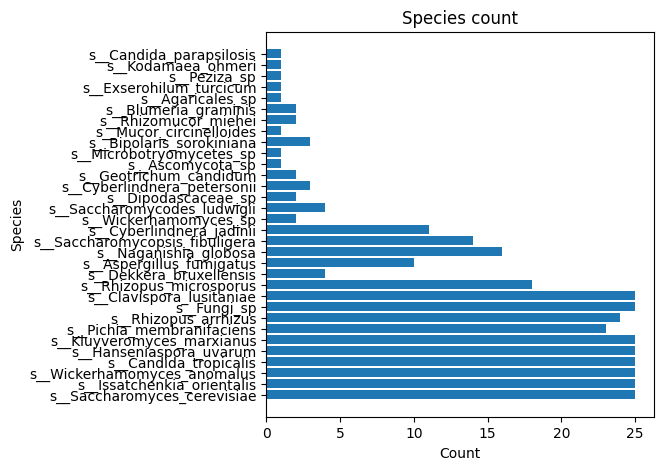

In [2]:
df = pd.read_csv('sesotho.csv')
columns = []
for col in df.columns:
    c = col.split(";")
    if c[-1] != '__' and c[0]=='k__Fungi':
        columns.append(col)

# print(columns)
df = df.filter(columns)

non_zero_cells = df[df != 0.0].count()

import matplotlib.pyplot as plt

# Create a list of species names and counts
species_names = [label.split(';')[-1].strip() for label in non_zero_cells.index.tolist()]
counts = non_zero_cells.tolist()

# Set up the plot
fig, ax = plt.subplots(figsize=(5, 5))
ax.barh(species_names, counts)

# Set the labels and title
ax.set_xlabel('Count')
ax.set_ylabel('Species')
ax.set_title('Species count')

# Display the plot
plt.show()

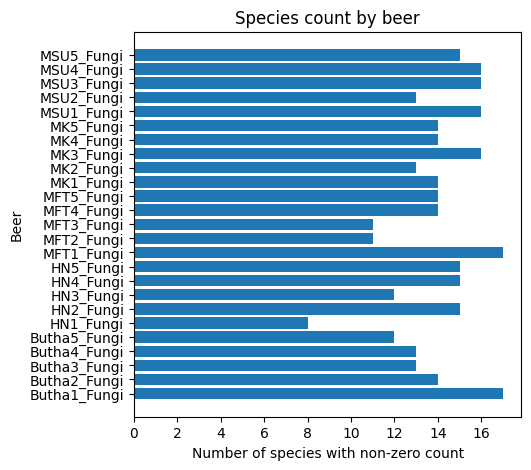

In [50]:
df = pd.read_csv('sesotho.csv')
columns = []
for col in df.columns:
    c = col.split(";")
    if c[-1] != '__' and (c[0]=='k__Fungi' or c[0]=='beer_id'):
        columns.append(col)

# print(columns)
df = df.filter(columns)

# Group the data by beer and sum the non-zero counts
grouped_df = df.groupby('beer_id').sum()
grouped_df['non_zero_count'] = (grouped_df > 0).sum(axis=1)

# Create a horizontal bar plot of non-zero counts by beer
fig, ax = plt.subplots(figsize=(5, 5))
ax.barh(grouped_df.index, grouped_df['non_zero_count'])

# Set the labels and title
ax.set_xlabel('Number of species with non-zero count')
ax.set_ylabel('Beer')
ax.set_title('Species count by beer')

# Set the x-axis ticks to show only integers
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Display the plot
plt.show()

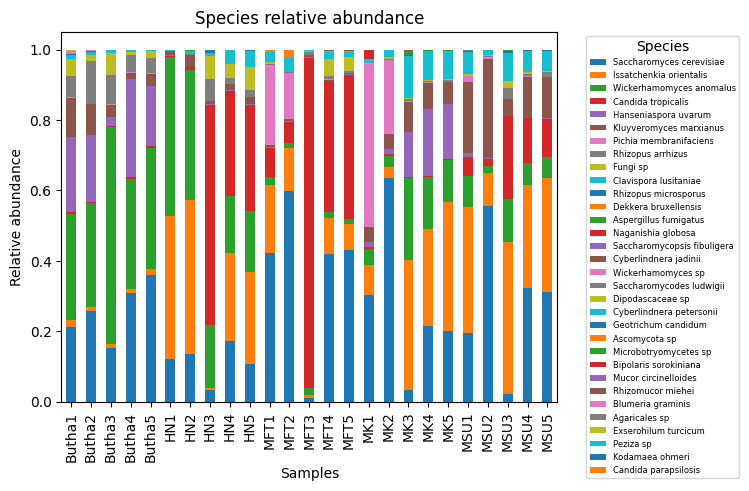

In [67]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('sesotho.csv')
columns = []
for col in df.columns:
    c = col.split(";")
    if c[-1] != '__' and (c[0]=='k__Fungi' or c[0]=='beer_id'):
        columns.append(col)

df = df.filter(columns)
df['beer_id'] = df['beer_id'].str.split('_').str[0]
new_columns = []
for label in df.columns.tolist():
    if label != 'beer_id':
        new_columns.append(label.split(';')[-1].strip()[3:].replace('_', ' '))
    else:
        new_columns.append('beer_id')

df.columns = new_columns

# Group the data by beer and sum the non-zero counts
grouped_df = df.groupby('beer_id').sum()

# Normalize the data to get relative abundance
normalized_df = grouped_df.div(grouped_df.sum(axis=1), axis=0)

# Calculate the threshold for species with relative abundance less than 1%
# threshold = 0.01
# low_abundance_species = normalized_df.max(axis=0) < threshold
# print(low_abundance_species[low_abundance_species].index.tolist())
# # Group low abundance species together and assign it a label
# low_abundance_label = 'Species less than 1% abundance'
# low_abundance_df = normalized_df.loc[:, low_abundance_species].sum(axis=1)
# normalized_df = normalized_df.loc[:, ~low_abundance_species]
# normalized_df[low_abundance_label] = low_abundance_df

# Plot the data
ax = normalized_df.plot.bar(rot=0, stacked=True)

# Set the title and labels
plt.title('Species relative abundance')
plt.ylabel('Relative abundance')
plt.xlabel('Samples')

# Rotate x-axis tick labels
plt.xticks(rotation='vertical')

# Place the legend to the right of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Species", prop={'size': 6})

# Save the plot as a PNG image
plt.savefig('sesotho_species_relative_abundance.png', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()


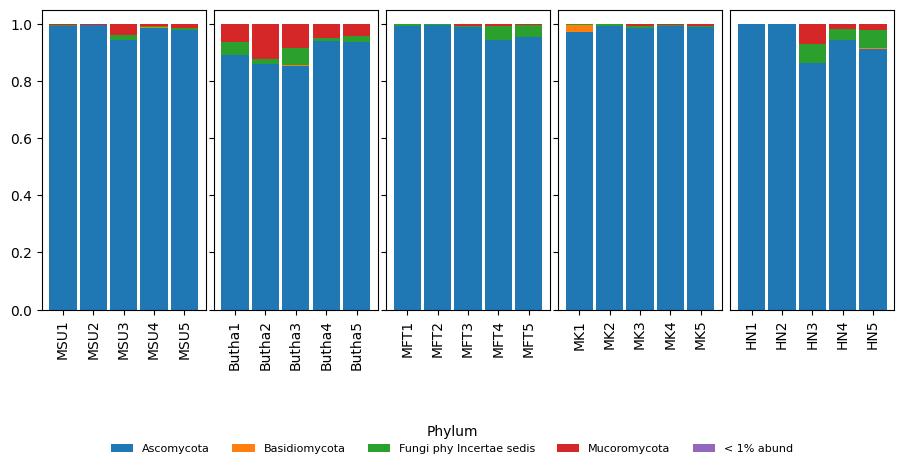

In [5]:
def myplot(df, my_level, legend_title, fig_name, plot_title):
    # Rename the columns to the genus name
    df.columns = ['beer_id' if col == 'beer_id' else col.split(';')[my_level][3:].replace('_', ' ') for col in df.columns]

    # Group the data by 'beer_id' and genus and sum the non-zero counts
    df = df.groupby(by=df.columns, axis=1).sum()

    # Group the data by 'beer_id' and sum the non-zero counts
    grouped_df = df.groupby('beer_id').sum()

    # Normalize the data to get relative abundance
    normalized_df = grouped_df.div(grouped_df.sum(axis=1), axis=0)

    # Threshold for the relative abundance
    threshold = 0.01  # 1%

    # Identify species with a maximum relative abundance across all samples less than the threshold
    low_abundance_species = normalized_df.max(axis=0) < threshold

    # Create a dataframe for low abundance species
    low_abundance_df = normalized_df.loc[:, low_abundance_species]

    # Remove the low abundance species from the dataframe
    normalized_df = normalized_df.loc[:, ~low_abundance_species]

    # Sum the relative abundances of the low abundance species and assign to a new 'Other' column
    normalized_df['< 1% abund'] = low_abundance_df.sum(axis=1)

    # Get the unique prefixes in the 'beer_id' column
    prefixes = set([name[:2] for name in normalized_df.index])

    # Calculate the number of rows and columns for the subplot grid
    n_cols = 5
    n_rows = int(np.ceil(len(prefixes) / n_cols))

    # Create a new figure with a defined size
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(11, 5 * n_rows), sharey=True)

    # Flatten the axes array for easy iteration
    axs = axs.flatten()

    # For each prefix, create a subset of the data and plot it
    for i, prefix in enumerate(prefixes):
        subset_df = normalized_df[[name.startswith(prefix) for name in normalized_df.index]]

        if not subset_df.empty:
            # Plot the data
            subset_df.plot.bar(rot=0, stacked=True, width=0.9, ax=axs[i])

            # Rotate x-labels
            axs[i].tick_params(axis='x', rotation=90)

            # Show y-tick labels only for the first graph
            if i == 1:
                plt.ylabel('Abundance')
                plt.gca().get_yaxis().set_visible(True)
            else:
                plt.ylabel('')
                plt.gca().get_yaxis().set_visible(False)
            axs[i].set_xlabel('')
            # Remove the legend
            axs[i].legend().set_visible(False)

#     fig.suptitle(plot_title, x=0.05, y=0.95, ha='left', va='top', fontsize=14)
    # Remove empty subplots
    if len(prefixes) < n_cols * n_rows:
        for j in range(len(prefixes), n_cols * n_rows):
            fig.delaxes(axs[j])

    # Create the combined legend
    handles, labels = axs[0].get_legend_handles_labels()
    legend = fig.legend(handles, labels, loc='lower center', ncol=5, title=legend_title, prop={'size': 8})
    legend.get_frame().set_linewidth(0)  # Remove legend border
    
    # Adjust spacing between subplots and legend
    plt.subplots_adjust(bottom=0.3, top=0.9, wspace=0.05, hspace=0.4)

    # Save the plot as a PNG image
    plt.savefig(fig_name, dpi=300)

    # Show the plot
    plt.show()

df = pd.read_csv('sesotho.csv')
columns = []
for col in df.columns:
    c = col.split(";")
    if c[-1] != '__' and (c[0] == 'k__Fungi' or c[0] == 'beer_id'):
        columns.append(col)

# Filter the columns
df = df.filter(columns)
df['beer_id'] = df['beer_id'].str.split('_').str[0]

# myplot(df, -2, 'Genus', 'sesotho_genus_relative_abundance.png', 'Distribution of Genera')
# myplot(df, -3, 'Families', 'sesotho_family_relative_abundance.png', 'Distribution of Family')
myplot(df, 1, 'Phylum', 'sesotho_phyla_relative_abundance.png', 'Distribution of Phyla')

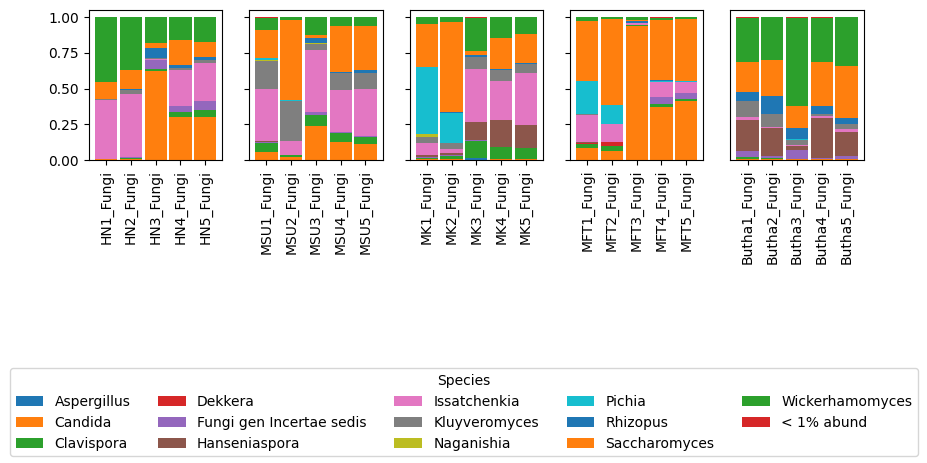

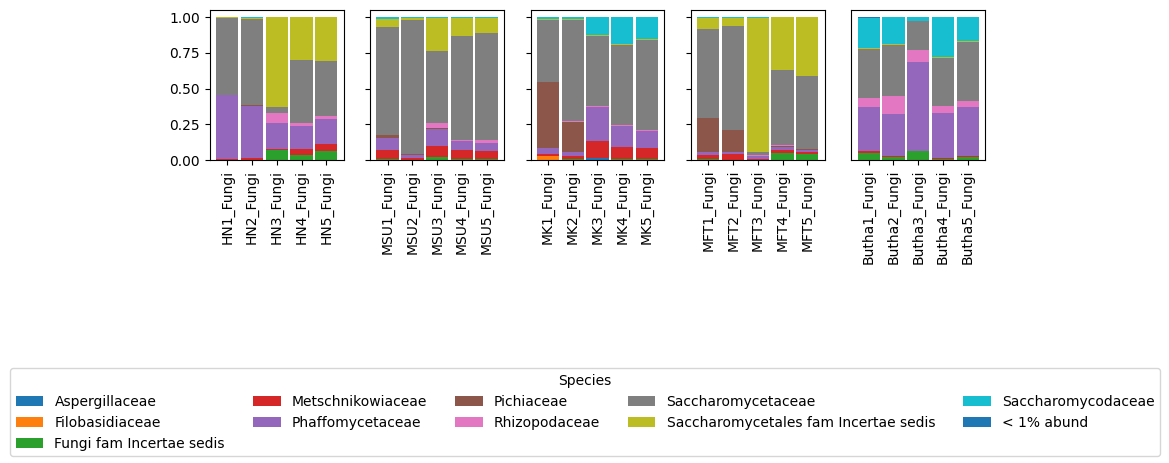

In [14]:
df = pd.read_csv('sesotho.csv')
columns = []
for col in df.columns:
    c = col.split(";")
    if c[-1] != '__' and (c[0] == 'k__Fungi' or c[0] == 'beer_id'):
        columns.append(col)

# Filter the columns
df = df.filter(columns)

# Rename the columns to the genus name
df.columns = ['beer_id' if col == 'beer_id' else col.split(';')[-3][3:].replace('_', ' ') for col in df.columns]

# Group the data by 'beer_id' and genus and sum the non-zero counts
df = df.groupby(by=df.columns, axis=1).sum()

# Group the data by 'beer_id' and sum the non-zero counts
grouped_df = df.groupby('beer_id').sum()

# Normalize the data to get relative abundance
normalized_df = grouped_df.div(grouped_df.sum(axis=1), axis=0)

# Threshold for the relative abundance
threshold = 0.01  # 1%

# Identify species with a maximum relative abundance across all samples less than the threshold
low_abundance_species = normalized_df.max(axis=0) < threshold

# Create a dataframe for low abundance species
low_abundance_df = normalized_df.loc[:, low_abundance_species]

# Remove the low abundance species from the dataframe
normalized_df = normalized_df.loc[:, ~low_abundance_species]

# Sum the relative abundances of the low abundance species and assign to a new 'Other' column
normalized_df['< 1% abund'] = low_abundance_df.sum(axis=1)

# Get the unique prefixes in the 'beer_id' column
prefixes = set([name[:2] for name in normalized_df.index])

# Calculate the number of rows and columns for the subplot grid
n_cols = 5
n_rows = int(np.ceil(len(prefixes) / n_cols))

# Create a new figure with a defined size
fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 5 * n_rows), sharey=True)

# Flatten the axes array for easy iteration
axs = axs.flatten()

# For each prefix, create a subset of the data and plot it
for i, prefix in enumerate(prefixes):
    subset_df = normalized_df[[name.startswith(prefix) for name in normalized_df.index]]

    if not subset_df.empty:
        # Plot the data
        subset_df.plot.bar(rot=0, stacked=True, width=0.9, ax=axs[i])

        # Rotate x-labels
        axs[i].tick_params(axis='x', rotation=90)
        
        # Show y-tick labels only for the first graph
        if i == 1:
            plt.ylabel('Abundance')
            plt.gca().get_yaxis().set_visible(True)
        else:
            plt.ylabel('')
            plt.gca().get_yaxis().set_visible(False)
        axs[i].set_xlabel('')
        # Remove the legend
        axs[i].legend().set_visible(False)
        

# Remove empty subplots
if len(prefixes) < n_cols * n_rows:
    for j in range(len(prefixes), n_cols * n_rows):
        fig.delaxes(axs[j])

# Create the combined legend
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=5, title='Species')

# Adjust spacing between subplots and legend
plt.subplots_adjust(bottom=0.6, top=0.9)

# Save the plot as a PNG image
plt.savefig('species_relative_abundance.png', dpi=300)

# Show the plot
plt.show()


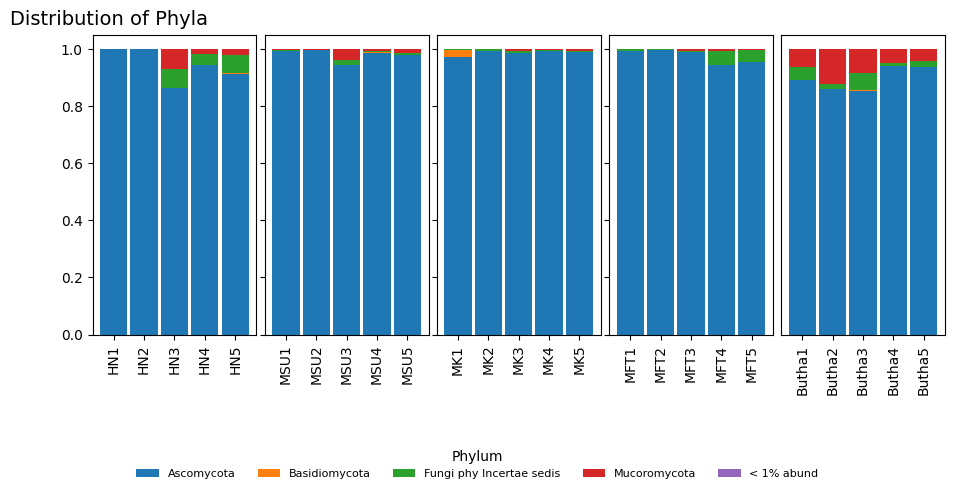